### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from io import StringIO
import json
import re
import ast
import statsmodels.api as sm
import warnings
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import pacf
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima.utils import ndiffs
import scipy.optimize as opt
from functools import partial

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

warnings.simplefilter(action='ignore', category=FutureWarning)

### Installs

In [2]:
%%capture
!pip install jsonpickle
!pip install pmdarima

### Pulling In Log Data

In [69]:
def parse_log_file(file_path):
    
    with open(file_path, 'r') as file:
        content = file.read()
    
    # Extract sections
    sandbox_section = re.search(r'Sandbox logs:(.*?)Activities log:', content, re.DOTALL).group(1).strip()
    activities_section = re.search(r'Activities log:(.*?)Trade History:', content, re.DOTALL).group(1).strip()
    trade_section = re.search(r'Trade History:(.*?)$', content, re.DOTALL).group(1).strip()
    
    # Function to parse multi-line JSON objects
    def extract_json_objects(json_string):
        # Split the string into lines
        lines = json_string.strip().split('\n')
        
        # Initialize variables
        json_objects = []
        current_object = ""
        inside_object = False
        
        for idx, line in enumerate(lines):
            if line.strip().startswith('{'):
                inside_object = True
                current_object = line
            elif line.strip().endswith('}') and inside_object:
                current_object += line
                json_objects.append(json.loads(current_object))
                current_object = ""
                inside_object = False
            elif inside_object:
                current_object += line
        
        return json_objects
    
    # Parse each section
    sandbox_logs = extract_json_objects(sandbox_section)
    activities_list = pd.read_csv(StringIO(activities_section), sep=';')
    trade_list = ast.literal_eval(trade_section)

    sandbox_dicts = {}
    
    own_trades_df = pd.DataFrame(columns=['symbol', 'price', 'quantity', 'buyer', 'seller', 'timestamp'])

    market_trades_df = pd.DataFrame(columns=['symbol', 'price', 'quantity', 'buyer', 'seller', 'timestamp'])
    
    bid_df = pd.DataFrame(columns=['symbol','bid_price', 'bid_volume','timestamp'])
    ask_df = pd.DataFrame(columns=['symbol','ask_price', 'ask_volume','timestamp'])

    position_df = pd.DataFrame(columns=['symbol', 'position', 'timestamp'])

    trader_orders_df = pd.DataFrame(columns=['timestamp', 'symbol', 'price', 'quantity', 'type'])
    trader_data_df = pd.DataFrame(columns=['timestamp', 'symbol', 'orderbook_theo', 'signal_theo', 'return', 'residual', 'expected_return'])

    timestamps  = list(range(0, 1 + (len(sandbox_logs) * 100), 100))

    market_trade_info_df = pd.DataFrame(columns=['timestamp', 'symbol', 'average_weighted_price', 'total_volume'])
    own_trade_info_df = pd.DataFrame(columns=['timestamp', 'symbol', 'average_weighted_price', 'total_volume'])

    for idx_log, log in enumerate(sandbox_logs):

        lambda_log = log['lambdaLog']
        try:
            if "LATEST\n" in lambda_log and "\nEND" in lambda_log:
                start_idx = lambda_log.find("LATEST\n") + len("LATEST\n")
                end_idx = lambda_log.find("\nEND")
                
                json_content = lambda_log[start_idx:end_idx]
                parsed = json.loads(json_content)

            else:
                parsed = json.loads(lambda_log)

        except:
            raise Exception("Error parsing log")
        

        sandbox_dicts[parsed['state']['timestamp']] = parsed

        parsed_own_trades_df = pd.DataFrame(parsed['state']["own_trades"], columns=['symbol', 'price', 'quantity', 'buyer', 'seller', 'timestamp'])

        parsed_own_trades_df = parsed_own_trades_df[parsed_own_trades_df['timestamp']  == parsed['state']['timestamp']- 100]

        if not parsed_own_trades_df.empty:
            own_trades_df = pd.concat([own_trades_df, parsed_own_trades_df], ignore_index=True)
            
        parsed_market_trades_df = pd.DataFrame(parsed['state']["market_trades"], columns=['symbol', 'price', 'quantity', 'buyer', 'seller', 'timestamp'])
        
        parsed_market_trades_df = parsed_market_trades_df[parsed_market_trades_df['timestamp']  == parsed['state']['timestamp']- 100]

        if not parsed_market_trades_df.empty:
            market_trades_df = pd.concat([market_trades_df, parsed_market_trades_df], ignore_index=True)

        for symbol, depth in parsed['state']['order_depths'].items():

            parsed_bid_df = pd.DataFrame(list(depth[0].items()), columns=['bid_price', 'bid_volume'])
            parsed_ask_df = pd.DataFrame(list(depth[1].items()), columns=['ask_price', 'ask_volume'])

            parsed_ask_df['ask_volume'] = np.abs(parsed_ask_df['ask_volume'])

            parsed_bid_df['symbol'] = symbol
            parsed_ask_df['symbol'] = symbol

            parsed_bid_df['timestamp'] = parsed['state']['timestamp']
            parsed_ask_df['timestamp'] = parsed['state']['timestamp']
            
            bid_df = pd.concat([bid_df, parsed_bid_df], ignore_index=True)
            ask_df = pd.concat([ask_df, parsed_ask_df], ignore_index=True)

        parsed_position_df = pd.DataFrame(list(parsed['state']['position'].items()), columns=['symbol', 'position'])

        parsed_position_df['timestamp'] = parsed['state']['timestamp']

        position_df = pd.concat([position_df, parsed_position_df], ignore_index=True)
        
        parsed_trader_data = json.loads(parsed['state']['trader_data'])

        if idx_log < 5:
            display(parsed_trader_data['maker_orders'][symbol])

        orders_df = pd.DataFrame(columns = ['symbol', 'price', 'quantity', 'type', 'order_type','offset_asked'])

        symbol_list = list(parsed_trader_data['orderbook_theos'].keys())
        info_df = pd.DataFrame({'symbol': symbol_list,
                                     'orderbook_theo': [parsed_trader_data['orderbook_theos'][symbol][-1] for symbol in symbol_list],
                                     'signal_theo': [parsed_trader_data['signal_theos'][symbol][-1] for symbol in symbol_list],
                                        'return': [parsed_trader_data['returns'][symbol][-1] for symbol in symbol_list],
                                        'residual': [parsed_trader_data['residuals'][symbol][-1] for symbol in symbol_list],
                                        'expected_return': [parsed_trader_data['expected_return'][symbol] for symbol in symbol_list]
                                        })
        
        info_df['timestamp'] = parsed['state']['timestamp']

        market_trade_info_df = pd.concat([market_trade_info_df, pd.DataFrame({'timestamp': parsed['state']['timestamp'],
                                             'symbol': list(parsed_trader_data['market_trades_data'].keys()),
                                             'average_weighted_price': [values['average_weighted_price'] for values in parsed_trader_data['market_trades_data'].values()],
                                             'total_volume': [values['total_volume'] for values in parsed_trader_data['market_trades_data'].values()],
                                        })], ignore_index=True)
        
        own_trade_info_df = pd.concat([own_trade_info_df, pd.DataFrame({'timestamp': parsed['state']['timestamp'],
                                        'symbol': list(parsed_trader_data['own_trades_data'].keys()),
                                        'average_weighted_price': [values['average_weighted_price'] for values in parsed_trader_data['own_trades_data'].values()],
                                        'total_volume': [values['total_volume'] for values in parsed_trader_data['own_trades_data'].values()],
                                })], ignore_index=True)


        for symbol in parsed_trader_data['maker_orders'].keys():
            maker_orders_df = pd.DataFrame(parsed_trader_data['maker_orders'][symbol], columns=['symbol', 'price', 'quantity','offset_asked']) if len(parsed_trader_data['maker_orders'][symbol]) > 0 else pd.DataFrame(columns=['symbol', 'price', 'quantity','offset_asked'])
            taker_orders_df = pd.DataFrame(parsed_trader_data['taker_orders'][symbol], columns=['symbol', 'price', 'quantity']) if len(parsed_trader_data['taker_orders'][symbol]) > 0 else pd.DataFrame(columns=['symbol', 'price', 'quantity'])

            maker_orders_df['type'] = 'maker'
            taker_orders_df['type'] = 'taker'
            taker_orders_df['offset_asked'] = np.nan

            dfs_to_concat = [df for df in [orders_df, maker_orders_df, taker_orders_df] if not df.empty]
            if dfs_to_concat: 
                orders_df = pd.concat(dfs_to_concat, ignore_index=True)


        orders_df['timestamp'] = parsed['state']['timestamp']
    
        if not info_df.empty:
            trader_data_df = pd.concat([trader_data_df, info_df], ignore_index=True)
        if not orders_df.empty:
            trader_orders_df = pd.concat([trader_orders_df, orders_df], ignore_index=True)

    trader_data_df = trader_data_df.groupby('symbol').apply(
        lambda x: x.assign(**{'return': x['return'].shift(-1)})
    ).sort_values('timestamp').reset_index(drop=True)
    
    trader_data_df['return'] = trader_data_df['return'].fillna(0)

    market_trades_df = market_trades_df.sort_values('timestamp')
    
    symbols = position_df['symbol'].unique()

    result_dfs = []

    for symbol in symbols:
        symbol_data = position_df[position_df['symbol'] == symbol]

        symbol_all_times = pd.DataFrame({
                'symbol': symbol,
                'timestamp': timestamps
            })
        
        symbol_merged = pd.merge(symbol_all_times, symbol_data, 
                                    on=['symbol', 'timestamp'], how='left')
            
        symbol_merged = symbol_merged.sort_values('timestamp')
        symbol_merged['position'] = symbol_merged['position'].ffill().fillna(0).astype('float64')

        result_dfs.append(symbol_merged)

    position_df = pd.concat(result_dfs, ignore_index=True)

    activities_df, trade_history_df = pd.DataFrame(activities_list), pd.DataFrame(trade_list)

    # Conversion for market_trade_info_df
    market_trade_info_df['timestamp'] = market_trade_info_df['timestamp'].astype(int)
    market_trade_info_df['symbol'] = market_trade_info_df['symbol'].astype(str)
    market_trade_info_df['average_weighted_price'] = market_trade_info_df['average_weighted_price'].astype(float)
    market_trade_info_df['total_volume'] = market_trade_info_df['total_volume'].astype(int)

    own_trade_info_df['timestamp'] = own_trade_info_df['timestamp'].astype(int)
    own_trade_info_df['symbol'] = own_trade_info_df['symbol'].astype(str)
    own_trade_info_df['average_weighted_price'] = own_trade_info_df['average_weighted_price'].astype(float)
    own_trade_info_df['total_volume'] = own_trade_info_df['total_volume'].astype(int)

    # Conversion for trader_orders_df
    trader_orders_df['timestamp'] = trader_orders_df['timestamp'].astype(int)
    trader_orders_df['symbol'] = trader_orders_df['symbol'].astype(str)
    trader_orders_df['price'] = trader_orders_df['price'].astype(int)
    trader_orders_df['quantity'] = trader_orders_df['quantity'].astype(int)
    trader_orders_df['type'] = trader_orders_df['type'].astype(str)
    # offset_asked is already float64

    # Conversion for trader_data_df
    trader_data_df['timestamp'] = trader_data_df['timestamp'].astype(int)
    trader_data_df['symbol'] = trader_data_df['symbol'].astype(str)
    trader_data_df['orderbook_theo'] = trader_data_df['orderbook_theo'].astype(float)
    trader_data_df['signal_theo'] = trader_data_df['signal_theo'].astype(float)

    # Conversion for position_df
    position_df['symbol'] = position_df['symbol'].astype(str)
    position_df['timestamp'] = position_df['timestamp'].astype(int)
    # position is already float64

    # Conversion for bid_df
    bid_df['symbol'] = bid_df['symbol'].astype(str)
    bid_df['bid_price'] = bid_df['bid_price'].astype(int)
    bid_df['bid_volume'] = bid_df['bid_volume'].astype(int)
    bid_df['timestamp'] = bid_df['timestamp'].astype(int)

    # Conversion for ask_df
    ask_df['symbol'] = ask_df['symbol'].astype(str)
    ask_df['ask_price'] = ask_df['ask_price'].astype(int)
    ask_df['ask_volume'] = ask_df['ask_volume'].astype(int)
    ask_df['timestamp'] = ask_df['timestamp'].astype(int)

    # Conversion for own_trades_df
    own_trades_df['symbol'] = own_trades_df['symbol'].astype(str)
    # price is already float64
    own_trades_df['quantity'] = own_trades_df['quantity'].astype(int)
    own_trades_df['buyer'] = own_trades_df['buyer'].astype(str)
    own_trades_df['seller'] = own_trades_df['seller'].astype(str)
    own_trades_df['timestamp'] = own_trades_df['timestamp'].astype(int)

    # Conversion for market_trades_df
    market_trades_df['symbol'] = market_trades_df['symbol'].astype(str)
    # price is already float64
    market_trades_df['quantity'] = market_trades_df['quantity'].astype(int)
    market_trades_df['buyer'] = market_trades_df['buyer'].astype(str)
    market_trades_df['seller'] = market_trades_df['seller'].astype(str)
    market_trades_df['timestamp'] = market_trades_df['timestamp'].astype(int)

    activities_df['product'] = activities_df['product'].astype(str)

    trade_history_df['buyer'] = trade_history_df['buyer'].astype(str)
    trade_history_df['seller'] = trade_history_df['seller'].astype(str)
    trade_history_df['symbol'] = trade_history_df['symbol'].astype(str)
    trade_history_df['currency'] = trade_history_df['currency'].astype(str)

    return sandbox_dicts, market_trade_info_df, own_trade_info_df, trader_orders_df, trader_data_df, position_df, bid_df, ask_df, own_trades_df, market_trades_df,  activities_df, trade_history_df


In [70]:
log_file_path = "C://Users//marco//Downloads//99cfb63e-8aeb-418c-bf0d-fde1189b5140.log"

sandbox_dicts, market_trade_info_df, own_trade_info_df, trader_orders_df, trader_data_df, position_df, bid_df, ask_df, own_trades_df, market_trades_df,  activities_df, trade_history_df = parse_log_file(log_file_path)

[['RAINFOREST_RESIN', 9999, 8, 2.681],
 ['RAINFOREST_RESIN', 10000, -7, 2.319],
 ['RAINFOREST_RESIN', 9998, 8, 3.072],
 ['RAINFOREST_RESIN', 10001, -8, 2.928],
 ['RAINFOREST_RESIN', 9997, 7, 2.536],
 ['RAINFOREST_RESIN', 10002, -7, 2.464],
 ['RAINFOREST_RESIN', 9995, 7, 2.268],
 ['RAINFOREST_RESIN', 10004, -7, 2.232]]

[['RAINFOREST_RESIN', 9999, 9, 3.259],
 ['RAINFOREST_RESIN', 10001, -12, 6.741],
 ['RAINFOREST_RESIN', 9998, 9, 3.304],
 ['RAINFOREST_RESIN', 9997, 8, 2.652],
 ['RAINFOREST_RESIN', 10002, -7, 2.348],
 ['RAINFOREST_RESIN', 9995, 7, 2.326],
 ['RAINFOREST_RESIN', 10004, -7, 2.174]]

[['RAINFOREST_RESIN', 9999, 9, 3.62],
 ['RAINFOREST_RESIN', 10001, -12, 6.38],
 ['RAINFOREST_RESIN', 9998, 9, 3.448],
 ['RAINFOREST_RESIN', 9997, 8, 2.724],
 ['RAINFOREST_RESIN', 10002, -7, 2.276],
 ['RAINFOREST_RESIN', 9995, 7, 2.362],
 ['RAINFOREST_RESIN', 10004, -7, 2.138]]

[['RAINFOREST_RESIN', 9999, 9, 3.906],
 ['RAINFOREST_RESIN', 10001, -12, 6.094],
 ['RAINFOREST_RESIN', 9998, 9, 3.562],
 ['RAINFOREST_RESIN', 9997, 8, 2.781],
 ['RAINFOREST_RESIN', 10002, -7, 2.219],
 ['RAINFOREST_RESIN', 9995, 7, 2.391],
 ['RAINFOREST_RESIN', 10004, -7, 2.109]]

[['RAINFOREST_RESIN', 9999, 10, 4.134],
 ['RAINFOREST_RESIN', 10001, -12, 5.866],
 ['RAINFOREST_RESIN', 9998, 9, 3.653],
 ['RAINFOREST_RESIN', 9997, 8, 2.827],
 ['RAINFOREST_RESIN', 10002, -7, 2.173],
 ['RAINFOREST_RESIN', 9995, 7, 2.413],
 ['RAINFOREST_RESIN', 10005, -8, 2.587]]

KeyboardInterrupt: 

### Description of All of the Dataframes

1.   market_trade_info_df: average weighted price, total_volume traded of market trades during timestamp

        We receive information about these trades in run() at timestamp t + 100

2.   own_trade_info_df: average weighted price, total_volume traded of own trades during timestamp

        We receive information about these trades in run() at timestamp t + 100

3.   trader_orders_df: timestamp, price, quantity, type of order (maker or taker), and offset demanded if maker

        Explaining Offset Demanded:
        - If the trader is a maker, the offset demanded is (Edge of Order Price to Theo) / (Std of Price Return)

4.   trader_data_df: timestamp, symbol, orderbook_theo, signal_theo, return, residual, expected_return

5.   position_df: current position at timestamp t

6.   bid_df: symbol, bid price, volume, timestamp

7.   ask_df: symbol, ask price, volume, timestamp

8.   own_trades_df: symbol, price, quantity, buyer, seller, timestamp

9.   market_trades_df: symbol, price, quantity, buyer, seller, timestamp

9.   activities_df: day, timestamp, product, Top 3 Order Book Levels, mid_price, profit_and_loss

10.  trade_history_df: market_trades_df + own_trades_df

### Sandbox Dictionary

1.   Parsed Dictionary From JSON


## Generating Theo = f(Orderbook, Market Trades, Own Trades)

Our goal is to generate a theo that is as close as possible to imc_theo_(t+1). We want every single trade we make to mark in as well as possible.



### Functions

In [9]:
def build_position_trajectory_with_pnl(own_trades: pd.DataFrame) -> pd.DataFrame:
    trades_sorted = own_trades.sort_values(by="timestamp").copy()
    pos_records = [{
            "timestamp": 0,
            "product": product,
            "position": 0,
            "cost_basis": np.nan,
            "realized_pnl": np.nan,
            "realized_pnl_cum": np.nan,
        } for product in own_trades['symbol'].unique()]
    
    # Track state by product
    state = {}
    

    for _, row in trades_sorted.iterrows():
        product = row["symbol"]
        t = row["timestamp"]
        qty = row["quantity"]
        px = row["price"]
        
        # Determine if we're buying or selling
        if row["buyer"] == "SUBMISSION":
            delta_pos = +qty  # We're buying
        elif row["seller"] == "SUBMISSION":
            delta_pos = -qty  # We're selling
        else:
            continue  # Not our trade
        
        # Initialize state for this product if not seen before
        if product not in state:
            state[product] = {
                "pos": 0.0,
                "cost_basis": 0.0,
                "realized_cum": 0.0
            }
        
        old_pos = state[product]["pos"]
        old_cb = state[product]["cost_basis"]
        old_realized = state[product]["realized_cum"]
                
        # Determine if we're opening, increasing, reducing, or closing a position
        if abs(old_pos) < 1e-10:  # No existing position
        # Opening a new position
            new_pos = delta_pos
            new_cb = px
            trade_realized = 0.0
        elif (old_pos > 0 and delta_pos > 0) or (old_pos < 0 and delta_pos < 0):
            total_pos = old_pos + delta_pos
            new_cb = (old_pos * old_cb + delta_pos * px) / total_pos
            new_pos = total_pos
            trade_realized = 0.0
        elif (old_pos > 0 and delta_pos < 0) or (old_pos < 0 and delta_pos > 0):
            # Trade in opposite direction of position
            # First determine if we're reducing or flipping the position
            if abs(delta_pos) <= abs(old_pos):
                # Reducing position
                trade_realized = -delta_pos * (px - old_cb) if old_pos > 0 else delta_pos * (old_cb - px)
                
                new_pos = old_pos + delta_pos
                new_cb = old_cb  # Cost basis stays the same when reducing
            else:

                # Flipping position (close existing and open new in opposite direction)
                # Calculate PnL on the closed portion
                trade_realized = old_pos * (px - old_cb) if old_pos > 0 else -old_pos * (old_cb - px)
                # # Remaining quantity becomes a new position
                new_pos = old_pos + delta_pos
                new_cb = px  # New cost basis is this trade's price
            

        # Update cumulative realized PnL
        new_realized_cum = old_realized + trade_realized
        
        # Clean up tiny values due to floating point issues
        if abs(new_pos) < 1e-10:
            new_pos = 0.0
            new_cb = 0.0
        
        # Update state
        state[product]["pos"] = new_pos
        state[product]["cost_basis"] = new_cb
        state[product]["realized_cum"] = new_realized_cum
        
        # Record this position update
        pos_records.append({
            "timestamp": t + 100,
            "product": product,
            "position": new_pos,
            "cost_basis": new_cb,
            "realized_pnl": trade_realized,
            "realized_pnl_cum": new_realized_cum
        })
    
    position_df = pd.DataFrame(pos_records)
    
    position_df = (
        position_df
        .sort_values(["product", "timestamp"])
        .groupby(["product", "timestamp"], as_index=False)
        .last()
    )
    
    return position_df

In [50]:
def calculate_theo_for_row(row: pd.Series, betas: tuple) -> float:

    second_level_weight, third_level_weight, own_trades_weight, market_trades_weight = betas

    weights = [1, second_level_weight, third_level_weight]

    bid_levels, ask_levels = [], []

    for idx in range(1, 4):
        if pd.notna(row[f"bid_price_{idx}"]) and pd.notna(row[f"bid_volume_{idx}"]) and row[f"bid_volume_{idx}"]>0:
            vol_scaled = row[f"bid_volume_{idx}"] * weights[idx-1]
            bid_levels.append((row[f"bid_price_{idx}"], vol_scaled))

        if pd.notna(row[f"ask_price_{idx}"]) and pd.notna(row[f"ask_volume_{idx}"]) and row[f"ask_volume_{idx}"]>0:
            vol_scaled = row[f"ask_volume_{idx}"] * weights[idx-1]
            ask_levels.append((row[f"ask_price_{idx}"], vol_scaled))


    if len(bid_levels) == 0 or len(ask_levels) == 0:
        return np.nan

    total_bid_volume = sum(x[1] for x in bid_levels)
    weighted_bid  = sum(x[0]*x[1] for x in bid_levels) / total_bid_volume

    total_ask_volume = sum(x[1] for x in ask_levels)
    weighted_ask  = sum(x[0]*x[1] for x in ask_levels) / total_ask_volume

    own_volume = row['total_volume_own'] * own_trades_weight
    market_volume = row['total_volume_market'] * market_trades_weight
    own_weighted_average_price = row['average_weighted_price_own'] * own_volume if own_volume > 0 else 0
    market_weighted_average_price = row['average_weighted_price_market'] * market_volume if market_volume > 0 else 0

    total_volume = total_bid_volume + total_ask_volume + own_volume + market_volume
    
    if total_volume < 1e-9:
        return np.nan
    
    microprice = (weighted_ask * total_bid_volume + weighted_bid * total_ask_volume + own_weighted_average_price + market_weighted_average_price) / total_volume

    return microprice

In [45]:
def compute_predicted_pnl(
    merged_df: pd.DataFrame,
    betas: tuple
) -> pd.DataFrame:
    

    merged_df[["position", "cost_basis", "realized_pnl", "realized_pnl_cum"]] = merged_df[["position", "cost_basis", "realized_pnl", "realized_pnl_cum"]].ffill().fillna(0.0)

    merged_df["theo_price"] = merged_df.apply(lambda x: calculate_theo_for_row(x, betas), axis=1)

    merged_df["imc_theo"] =  np.where(merged_df['position'] == 0,
                                   np.nan,
                                   merged_df['cost_basis'] + ((merged_df['profit_and_loss'] - merged_df['realized_pnl_cum']) / merged_df['position']))
    merged_df["imc_theo"] = merged_df["imc_theo"].ffill()

    merged_df["error_theo"] = merged_df["imc_theo"] - merged_df["theo_price"]

    return merged_df 

In [46]:
def mse_pnl(merged_df, betas, verbose=False):

    df = compute_predicted_pnl(merged_df, betas)

    if verbose:
        print(betas)

    mse = np.mean(df[~np.isnan(df['error_theo'])]["error_theo"]**2)

    return df, mse

In [47]:
def objective(betas, merged_df, verbose=False):

    _, mse_val = mse_pnl(
        merged_df,
        betas,
        verbose=verbose
    )
    
    return mse_val

In [29]:
symbols = own_trades_df['symbol'].unique()
timestamps = list(sorted(activities_df['timestamp'].unique()))

position_pnl_df = build_position_trajectory_with_pnl(own_trades_df)

result_dfs = []

for symbol in symbols:

    symbol_data = position_pnl_df[position_pnl_df['product'] ==  symbol]

    symbol_all_times = pd.DataFrame({
            'product': symbol,
            'timestamp': timestamps
        })
    
    symbol_merged = pd.merge(symbol_all_times, symbol_data, 
                                on=['product', 'timestamp'], how='left')
        
    symbol_merged = symbol_merged.sort_values('timestamp')
    symbol_merged['position'] = symbol_merged['position'].ffill().fillna(0).astype('float64')

    result_dfs.append(symbol_merged)

position_df = pd.concat(result_dfs, ignore_index=True)

activities_df = activities_df.sort_values(["product", "timestamp"], ascending=[True, True])
position_df = position_df.sort_values(["product", "timestamp"], ascending=[True, True])

In [57]:
init_guess = (1, 1, 1, 1)
init_guess_one_level = (0, 0, 0, 0)

bounds = [(0, 2)]*4

theo_betas = {}
cleaned_theos = {}

for product in position_df['product'].unique():

    merged_product_df = pd.merge(
        activities_df[activities_df['product'] == product],
        position_pnl_df[position_pnl_df['product'] == product],
        on=["product","timestamp"],
        how = "left"
    ).rename(columns={'product': 'symbol'}).merge(
        market_trade_info_df[market_trade_info_df['symbol'] == product],
        on=['timestamp', 'symbol'],
        suffixes=('', '_market'),
        how='left'
    ).rename(columns={'total_volume': 'total_volume_market', 'average_weighted_price': 'average_weighted_price_market'}).merge(
        own_trade_info_df[own_trade_info_df['symbol'] == product],
        on=['timestamp', 'symbol'],
        suffixes=('', '_own'),
        how='left'
    ).rename(columns={'total_volume': 'total_volume_own', 'average_weighted_price': 'average_weighted_price_own'})
    
    init_one_level_params_mse = objective(init_guess_one_level,
                         merged_product_df)
    
    init_params_mse = objective(init_guess,
                         merged_product_df)
    
    product_objective = partial(objective,
                               merged_df = merged_product_df,
                               verbose=False)
    
    result = opt.minimize(
        product_objective,
        x0=init_guess,
        method='SLSQP',
        bounds=bounds,
        options={"eps": 1e-4}
    )

    mse_df, mse_val = mse_pnl(
        betas = result.x,
        merged_df = merged_product_df,
        verbose=False
    )

    cleaned_theos[product] = mse_df[['timestamp', 'theo_price','imc_theo']].copy()

    cleaned_theos[product].loc[:, 'return_theo'] = cleaned_theos[product]['theo_price'].pct_change().shift(-1).fillna(0)
    cleaned_theos[product].loc[:, 'return_mtm'] = (cleaned_theos[product]['imc_theo'].shift(-1) / cleaned_theos[product]['theo_price']) - 1
    cleaned_theos[product].loc[:, 'next_imc_theo'] = cleaned_theos[product]['imc_theo'].shift(-1)

    print(f"Optimization result for product {product}:", result)
    print(f"Best betas for product {product}:", result.x)
    print(f"One Level Raw MSE for product {product}:", init_one_level_params_mse)
    print(f"Three Level Raw MSE for product {product}:", init_params_mse)
    print(f"MSE for product {product}:", result.fun)

    theo_betas[product] = result.x

cleaned_theos_df = pd.concat(cleaned_theos.values(), ignore_index=True)

Optimization result for product KELP:  message: Optimization terminated successfully
 success: True
  status: 0
     fun: 0.03943494499063699
       x: [ 8.704e-01  7.084e-01  2.295e-01  2.322e-01]
     nit: 16
     jac: [-1.635e-05  1.039e-04 -2.396e-04  2.105e-04]
    nfev: 80
    njev: 16
Best betas for product KELP: [0.8704056  0.7084226  0.22948839 0.2321712 ]
One Level Raw MSE for product KELP: 0.19235870937754185
Three Level Raw MSE for product KELP: 0.048885179340345274
MSE for product KELP: 0.03943494499063699
Optimization result for product RAINFOREST_RESIN:  message: Optimization terminated successfully
 success: True
  status: 0
     fun: 24.33243283368038
       x: [ 7.977e-01  5.545e-01  2.000e+00  4.422e-02]
     nit: 15
     jac: [ 9.326e-05  4.441e-05 -3.043e-02 -8.276e-05]
    nfev: 76
    njev: 15
Best betas for product RAINFOREST_RESIN: [0.79771619 0.55453754 2.         0.0442225 ]
One Level Raw MSE for product RAINFOREST_RESIN: 27.161435794381802
Three Level Raw MS

### Verification of IMC Theo

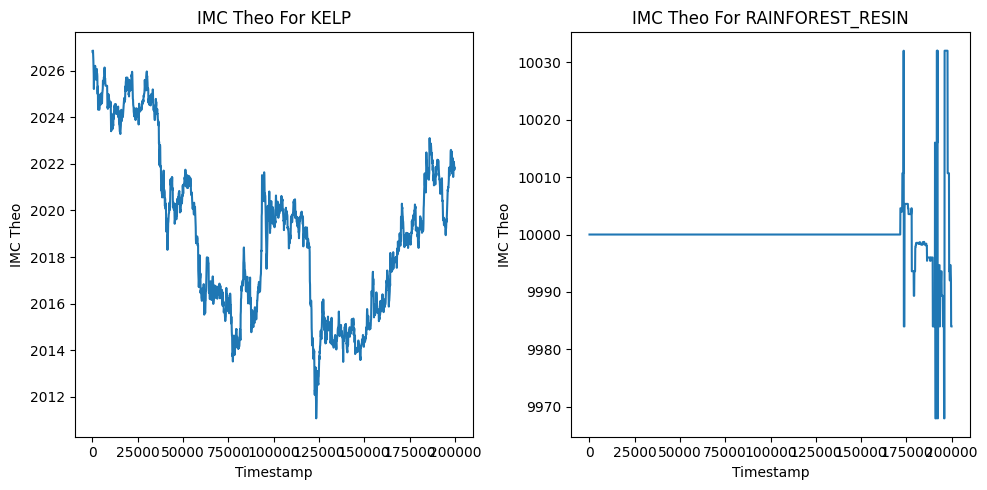

In [59]:
n_symbols = len(cleaned_theos.keys())

fig, axes = plt.subplots(1, n_symbols, figsize=(5*n_symbols, 5))

if n_symbols == 1:
    axes = np.array([axes])

for i, symbol in enumerate(cleaned_theos.keys()):

    axes[i].plot(cleaned_theos[symbol]['timestamp'], cleaned_theos[symbol]['imc_theo'])
    axes[i].set_title(f'IMC Theo For {symbol}')
    axes[i].set_xlabel('Timestamp')
    axes[i].set_ylabel('IMC Theo')

plt.tight_layout()
plt.show()

## Signal Creation

### Objective Function

### HAR Regression Function

### ARIMA Regression Function


### Testing For P and Q

## Production Quoting Optimization

### Preprocessing

In [67]:
# Examining Quantity Filled

maker_orders = trader_orders_df[trader_orders_df['type'] == 'maker'].copy()

buy_trades = own_trades_df[own_trades_df['buyer'] == 'SUBMISSION'].copy()
sell_trades = own_trades_df[own_trades_df['seller'] == 'SUBMISSION'].copy()

trader_orders_df['quantity_filled'] = 0

buy_merged = maker_orders[maker_orders['quantity'] > 0].merge(
    buy_trades,
    on=['timestamp', 'price', 'symbol'],
    how='left',
    suffixes=('', '_trade')
)
sell_merged = maker_orders[maker_orders['quantity'] < 0].merge(
    sell_trades,
    on=['timestamp', 'price', 'symbol'],
    how='left',
    suffixes=('', '_trade')
)

filled_orders = pd.concat([buy_merged, sell_merged])

trader_orders_df['quantity_filled'] = trader_orders_df['quantity_filled'].fillna(0)

trader_orders_df.sort_values(by=['timestamp', 'symbol','price'], inplace=True)

display(trader_orders_df.head(20))
# # Examining 1 Tick Markout

# trader_orders_df = trader_orders_df.merge(cleaned_theos_df[['timestamp', 'symbol', 'next_imc_theo']], on=['timestamp', 'symbol'], how='left').merge(trader_data_df[['timestamp', 'symbol', 'signal_theo']], on=['timestamp', 'symbol'], how='left')

# filled_orders = trader_orders_df[trader_orders_df['quantity_filled'] > 0]

# filled_orders['expected_edge_per_contract'] = np.where(filled_orders['buyer_trade'] == 'SUBMISSION', filled_orders['signal_theo'] - filled_orders['price'], filled_orders['price'] - filled_orders['signal_theo'])
# filled_orders['retained_edge_per_contract'] = np.where(filled_orders['buyer_trade'] == 'SUBMISSION', filled_orders['next_imc_theo'] - filled_orders['price'], filled_orders['price'] - filled_orders['next_imc_theo'])

# filled_orders['expected_edge'] = filled_orders['expected_edge_per_contract'] * filled_orders['quantity_filled']
# filled_orders['retained_edge'] = filled_orders['retained_edge_per_contract'] * filled_orders['quantity_filled']

# filled_orders['fill_percentage'] = filled_orders['quantity_filled'] / filled_orders['quantity']

# filled_orders['offset_bucket'] = pd.cut(filled_orders['offset_asked'], bins=[-np.inf, 0, 0.5, 1, 1.5, 2, np.inf], labels=['-', '0-0.5', '0.5-1', '1-1.5', '1.5-2', '2+'])
# filled_orders['fill_percentage_bucket'] = pd.cut(filled_orders['fill_percentage'], bins=[-np.inf, 0.3, 0.8, 1], labels=['0-0.3', '0.3-0.8', '0.8-1'])


,timestamp,symbol,price,quantity,type,offset_asked,quantity_filled
11,0,KELP,2025,4,maker,0.918,0
8,0,KELP,2026,10,maker,4.180,0
9,0,KELP,2027,-4,maker,0.820,0
10,0,KELP,2028,-7,maker,2.328,0
12,0,KELP,2029,-5,maker,1.082,0
6,0,RAINFOREST_RESIN,9995,7,maker,2.268,0
4,0,RAINFOREST_RESIN,9997,7,maker,2.536,0
2,0,RAINFOREST_RESIN,9998,8,maker,3.072,0
0,0,RAINFOREST_RESIN,9999,8,maker,2.681,0
1,0,RAINFOREST_RESIN,10000,-7,maker,2.319,0


### Edge Retained Statistics

For every product, we want to calculate the following statistics:
1.   Cash Edge, Percentage of Edge Retained Over 1 Tick
2.   Cash Edge, Percentage of Edge Retained By Offset Bucket [(0, 0.5), (0.5, 1), (1, 1.5), (1.5, 2), (2+)]
3.   Cash Edge, Percentage of Edge Retained Over Fill Percentage Bucket [(0, 0.3), (0.3, 0.8), (0.8, 1)] And Offset Bucket [(0, 1), (1, 2), (2+)]

In [ ]:
# Cash Edge Retained Over 1 Tick

cash_edge_retained_summary = filled_orders.groupby(['symbol']).agg({
    'retained_edge': 'sum',
    'expected_edge': 'sum'
})

display(cash_edge_retained_summary)

# Percentage of Edge Retained Over 1 Tick

percentage_edge_retained_summary = pd.DataFrame({'percentage_retained': cash_edge_retained_summary['retained_edge'] / cash_edge_retained_summary['expected_edge']})

display(percentage_edge_retained_summary)

# Cash Edge Retained By Offset Bucket

cash_edge_retained_offset_summary = filled_orders.groupby(['symbol', 'offset_bucket']).agg({
    'retained_edge': 'sum',
    'expected_edge': 'sum'
})

display(cash_edge_retained_offset_summary)

# Percentage of Edge Retained By Offset Bucket

percentage_edge_retained_offset_summary = pd.DataFrame({'percentage_retained': cash_edge_retained_offset_summary['retained_edge'] / cash_edge_retained_offset_summary['expected_edge']})

display(percentage_edge_retained_offset_summary)

# Cash Edge Retained Over Fill Percentage Bucket And Offset Bucket

cash_edge_retained_offset_fill_summary = filled_orders.groupby(['symbol', 'offset_bucket', 'fill_percentage_bucket']).agg({
    'retained_edge': 'sum',
    'expected_edge': 'sum'
})

display(cash_edge_retained_offset_fill_summary)

# Percentage of Edge Retained Over Fill Percentage Bucket And Offset Bucket

percentage_edge_retained_offset_fill_summary = pd.DataFrame({'percentage_retained': cash_edge_retained_offset_fill_summary['retained_edge'] / cash_edge_retained_offset_fill_summary['expected_edge']})

display(percentage_edge_retained_offset_fill_summary)


### Autocorrelation of Trade Direction

Given dPos_maker(t), we want correlation of dPos_maker(t) with dPos_maker(t-1)

## Production Taking Optimization

### Taking Opportunities, How Many Do We Capture

In [ ]:
for product in cleaned_theos.keys():
    
    print(f"Product: {product}")

    activities_product_df = activities_df[activities_df['product'] == product]

    sell_opportunities_mask = activities_product_df['theo_price'].shift(-1) < activities_product_df['bid_price_1']
    buy_opportunities_mask = activities_product_df['theo_price'].shift(-1) > activities_product_df['ask_price_1']

    print(f"Proportion of Sell Opportunities: {np.mean(sell_opportunities_mask)}")
    print(f"Proportion of Buy Opportunities: {np.mean(buy_opportunities_mask)}")

    sell_opportunities_timestamps = activities_product_df[sell_opportunities_mask]['timestamp']
    buy_opportunities_timestamps = activities_product_df[buy_opportunities_mask]['timestamp']


### OOS Signal / Return Performance

In [ ]:
for symbol in trader_data_df['symbol'].unique():
    symbol_mask = trader_data_df['symbol'] == symbol
    X = trader_data_df[symbol_mask][['expected_return']]
    y = trader_data_df[symbol_mask]['return'].fillna(0)
    signal_model = sm.OLS(y, sm.add_constant(X)).fit()
    print(f"Symbol: {symbol}, R-squared: {signal_model.rsquared}, Correlation: {signal_model.rsquared ** 0.5}, Beta: {signal_model.params[1]}")

### Plotting Expected Return vs Return

In [ ]:
n_symbols = len(trader_data_df['symbol'].unique())

fig, axes = plt.subplots(1, n_symbols, figsize=(5*n_symbols, 5), sharey=True)

if n_symbols == 1:
    axes = np.array([axes])

for i, symbol in enumerate(trader_data_df['symbol'].unique()):
    symbol_mask = trader_data_df['symbol'] == symbol

    axes[i].scatter(trader_data_df[symbol_mask]['expected_return'], trader_data_df[symbol_mask]['return'])

    min_val, max_val = min(trader_data_df[symbol_mask]['expected_return']), max(trader_data_df[symbol_mask]['expected_return']) 

    axes[i].plot([min_val, max_val], [min_val, max_val], 'r-')
    axes[i].set_title(f'{symbol} Signal vs Return')
    axes[i].set_xlabel('Expected Return')
    axes[i].set_ylabel('Return')

plt.tight_layout()
plt.show()

### Edge Retention Analysis - Taking Orders

## Inventory Management


### Plotting Position

In [ ]:
n_symbols = len(trader_data_df['symbol'].unique())

fig, axes = plt.subplots(1, n_symbols, figsize=(5*n_symbols, 5), sharey=True)

if n_symbols == 1:
    axes = np.array([axes])

for i, symbol in enumerate(trader_data_df['symbol'].unique()):
    symbol_mask = trader_data_df['symbol'] == symbol

    axes[i].scatter(trader_data_df[symbol_mask]['expected_return'], trader_data_df[symbol_mask]['return'])

    min_val, max_val = min(trader_data_df[symbol_mask]['expected_return']), max(trader_data_df[symbol_mask]['expected_return']) 

    axes[i].plot([min_val, max_val], [min_val, max_val], 'r-')
    axes[i].set_title(f'{symbol} Signal vs Return')
    axes[i].set_xlabel('Expected Return')
    axes[i].set_ylabel('Return')

plt.tight_layout()
plt.show()

### Plotting Position And PnL

## Volatility Forecasting

### EWMA for Variance

In [ ]:
def ewma_variance(returns, alpha, init_period=10):

    ewma_var = np.zeros_like(returns)
    for t in range(1, len(returns)):
        ewma_var[t] = (1 - alpha) * ewma_var[t-1] + alpha * returns[t-1]**2 
    return ewma_var

### Feature Generation

In [ ]:
init_period = 50
alphas_ewma = np.array([0.9, 0.95, 0.96, 0.97, 0.98, 0.99])

mean_variance = {}
variance_alphas = {}
variance_betas = {}

for product in cleaned_theos.keys():
    
    y = cleaned_theos[product]['return_theo'].values

    future_variance = y[init_period:] ** 2

    ewma_predictors = np.zeros((len(future_variance), len(alphas_ewma)))
    for i, alpha_ewma in enumerate(alphas_ewma):
        ewma_var = ewma_variance(y, alpha_ewma)
        predictor = ewma_var[init_period-1:-1]  # Predict variance using previous EWMA (X)
        ewma_predictors[:, i] = predictor

    # Add constant term for intercept
    X = ewma_predictors

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_mean = scaler.mean_
    X_std = scaler.scale_

    # Fit Lasso with cross-validation to find the best alpha
    lasso = LassoCV(cv=5, alphas=np.logspace(-4, 2, 100), max_iter=10000).fit(X, future_variance)

    # Get R-squared
    r_squared = lasso.score(X, future_variance)

    coef_scaled = lasso.coef_  # LASSO coefficients (for standardized X)
    intercept_scaled = lasso.intercept_

    # Rescale non-constant coefficients
    coef_original = coef_scaled / X_std  # Rescale slopes
    intercept_original = intercept_scaled - np.sum(coef_scaled * X_mean / X_std)  # Adjust intercept

    # Combine intercept and rescaled coefficients
    coef_names = ['Constant'] + [f'Alpha_{alpha_ewma}' for alpha_ewma in alphas_ewma]
    coef_values = np.hstack(([intercept_original], coef_original))

    # Print summary
    coef_df = pd.DataFrame({'Coefficient': coef_names, 'Value': coef_values})
    print(f"Product: {product}")
    print(coef_df.to_string(index=False))
    print(f"R-squared: {r_squared:.4f}\n")

    coef_alphas = coef_values[1:]
    alphas_selected = alphas_ewma[coef_alphas > 0]
    coef_non_zero = np.concatenate(([intercept_original], coef_alphas[coef_alphas > 0]))

    # Assigning Parameters
    mean_variance[product] = np.mean(y)
    variance_alphas[product] = alphas_selected
    variance_betas[product] = coef_non_zero
    

    



## Random Code

In [ ]:
import itables
import itables.options as opt
opt.precision = 8 
itables.show(own_trades_df)

In [ ]:

    def har_all_features_for_product(series, lags, window_y=1):
        df = pd.DataFrame(series)
        lag_features = np.zeros((df.shape[0], len(lags)))
        for i, lag in enumerate(lags):
            if i == 0:
                lag_features[:, i] = df.rolling(lag).mean().shift(1).values.flatten()
            else:
                prev_lag = lags[i-1]
                lag_features[:, i] = (
                    (df.rolling(lag).sum().shift(1) - df.rolling(prev_lag).sum().shift(1)) / (lag - prev_lag)
                ).values.flatten()
        features_y = np.zeros(df.shape[0])
        for i in range(len(df) - window_y + 1):
            features_y[i] = df.iloc[i:i+window_y].mean().values[0]
        start_idx = max(lags)
        end_idx = len(df) - window_y + 1
        return lag_features[start_idx:end_idx], features_y[start_idx:end_idx]

